# TASK 3

In [1]:
import numpy as np
import pandas as pd
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score
from pgmpy.models.BayesianModel import BayesianModel
from sklearn.utils import shuffle

In [2]:
seen_data = "seen-dataset/dataset_seen_training_siamese.csv"
seen_validation_data = "seen-dataset/dataset_seen_validation_siamese.csv"
seenValidImagePath  = 'seen-dataset/ValidationSet/'
seenTrainImagePath = 'seen-dataset/TrainingSet/'
shuffled_data = "shuffled-dataset/dataset_seen_training_siamese.csv"
shuffled_validation_data = "shuffled-dataset/dataset_seen_validation_siamese.csv"
shuffledValidImagePath  = 'shuffled-dataset/ValidationSet/'
shuffledTrainImagePath = 'shuffled-dataset/TrainingSet/'
unseen_data = "unseen-dataset/dataset_seen_training_siamese.csv"
unseen_validation_data = "unseen-dataset/dataset_seen_validation_siamese.csv"
unseenValidImagePath  = 'unseen-dataset/ValidationSet/'
unseenTrainImagePath = 'unseen-dataset/TrainingSet/'

In [4]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Reshape, UpSampling2D
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers import Activation, Dense, Flatten
from sklearn.metrics import accuracy_score
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, TensorBoard
from keras import optimizers
from PIL import Image
import os
import numpy as np
import imghdr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score 
from sklearn.metrics import recall_score 

Using TensorFlow backend.


In [0]:
def generateValidationSet(dataset):
    valid_data = pd.read_csv(dataset).drop('Unnamed: 0', axis=1)
    valid_data = shuffle(valid_data).reset_index(drop=True)
    leftImg = valid_data['left']
    rightImg = valid_data['right']
    target = valid_data['label']
    return leftImg,rightImg,target

In [0]:
def generateVaildationImageSet(validationImagePath,leftImg,rightImg):
    LeftMat  = []
    RightMat  = []
    #seenValidPath  = 'seen-dataset/ValidationSet/'
    for i in range(0,len(leftImg)):
        imgLeft  = Image.open(validationImagePath + leftImg[i],'r').convert('L')
        imgRight  = Image.open(validationImagePath + rightImg[i],'r').convert('L')
        imgLeftdata = (255-np.array(imgLeft.getdata()))/255
        imgRightdata = (255-np.array(imgRight.getdata()))/255
        LeftMat.append(imgLeftdata)
        RightMat.append(imgRightdata)
        
    LeftMat = np.array(LeftMat)
    LeftMat.resize(len(LeftMat),64,64,1)
    print(LeftMat.shape)

    RightMat = np.array(RightMat)
    RightMat.resize(len(RightMat),64,64,1)
    print(RightMat.shape)
    return LeftMat,RightMat

In [0]:
def generateTraininigImageSet(trainingPath):
    TrainMat  = []
    #curPath  = 'seen-dataset/TrainingSet/'
    curFolderPath = trainingPath 
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        img = Image.open(curImg,'r').convert('L')
        imgdata = (255-np.array(img.getdata()))/255
        TrainMat.append(imgdata)
        
    TrainMat = np.array(TrainMat)
    TrainMat.resize(len(TrainMat),64,64,1)
    print(TrainMat.shape)
    return TrainMat

# AUTOENCODER

In [0]:
def createAutoEncoder():
    input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format
    # x = CoordinateChannel2D()(input_img)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    # x = CoordinateChannel2D()(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    # x = CoordinateChannel2D()(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Flatten()(x)
    encoded = Dense(8*8*8, activation='relu', name='latent')(encoded)
    # model = Model(input_img,encoded)
    # print(model.summary())
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional
    r = Reshape(target_shape=(8,8,8))(encoded)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(r)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

    autoencoder = Model(input_img, decoded)
    
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    autoencoder.summary()
    return autoencoder

In [0]:
from keras.preprocessing.image import ImageDataGenerator
def runAutoncoder(TrainMat,autoencoder):
    
    no_epochs = 10
    batch = 32
    valid_percent = 20
    train_len = int(((100-valid_percent)/100)*len(TrainMat))
    valid_len = len(TrainMat) - train_len
 
    # construct the training image generator for data augmentation
    aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
        width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
        horizontal_flip=True, fill_mode="nearest")

    valid_gen = aug.flow(TrainMat[valid_len:len(TrainMat)],
                     TrainMat[valid_len:len(TrainMat)], batch_size=batch)

    # train the network
    history = autoencoder.fit_generator(aug.flow(TrainMat[0:train_len], TrainMat[0:train_len], batch_size=batch)
        , steps_per_epoch=len(TrainMat[0:train_len]) // batch,
        epochs=no_epochs,validation_data=valid_gen,validation_steps=valid_len // batch)
    return history,autoencoder

### SEEN DATASET

In [57]:
seenLeftImg,seenRightImg,seenTarget = generateValidationSet(seen_validation_data)
seenLeftMat,seenRightMat = generateVaildationImageSet(seenValidImagePath,seenLeftImg,seenRightImg)
seenTrainMat = generateTraininigImageSet(seenTrainImagePath)

(906, 64, 64, 1)
(906, 64, 64, 1)
(12846, 64, 64, 1)


In [58]:
seenAutoencoder = createAutoEncoder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 16, 16, 8)         584       
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
__________

In [59]:
history,seenTrainedAutoencoder = runAutoncoder(seenTrainMat,seenAutoencoder)

Epoch 1/10
321/321 [==============================] - 13s 39ms/step - loss: 0.2197 - acc: 0.8841 - val_loss: 0.1698 - val_acc: 0.8884
Epoch 2/10
321/321 [==============================] - 11s 35ms/step - loss: 0.1679 - acc: 0.8884 - val_loss: 0.1660 - val_acc: 0.8884
Epoch 3/10
321/321 [==============================] - 11s 35ms/step - loss: 0.1659 - acc: 0.8883 - val_loss: 0.1627 - val_acc: 0.8897
Epoch 4/10
321/321 [==============================] - 11s 35ms/step - loss: 0.1649 - acc: 0.8883 - val_loss: 0.1638 - val_acc: 0.8888
Epoch 5/10
321/321 [==============================] - 11s 35ms/step - loss: 0.1641 - acc: 0.8883 - val_loss: 0.1642 - val_acc: 0.8876
Epoch 6/10
321/321 [==============================] - 11s 35ms/step - loss: 0.1629 - acc: 0.8883 - val_loss: 0.1623 - val_acc: 0.8883
Epoch 7/10
321/321 [==============================] - 11s 35ms/step - loss: 0.1625 - acc: 0.8882 - val_loss: 0.1602 - val_acc: 0.8890
Epoch 8/10
321/321 [==============================] - 11s 35ms

In [60]:
seenEncoder = Model(seenTrainedAutoencoder.inputs, seenTrainedAutoencoder.get_layer('latent').output)
seenEncoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 16, 16, 8)         584       
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
__________

In [0]:

seen_left_img_encoded = seenEncoder.predict(seenLeftMat)
seen_right_img_encoded = seenEncoder.predict(seenRightMat)

In [0]:
def cos_sim(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

In [0]:
predicted = []
from numpy import dot
from numpy.linalg import norm
for i in range(0,len(seen_left_img_encoded)):
    a = seen_left_img_encoded[i]
    b = seen_right_img_encoded[i]
   
    predicted.append(cos_sim(a,b))

In [64]:
print("Seen Training Accuracy : " + str((history.history['acc'][4])*100))
print("Seen Training Loss : " + str((history.history['loss'][4])))
print("Seen Validation Accuracy while training on split data : " + str((history.history['val_acc'][4])*100))
print("Seen Validation loss while training on split data: " + str((history.history['val_loss'][4])))
print("Seen Validation/Test Dataset Accuracy: "+ str(roc_auc_score(seenTarget, predicted)*100))
print("Seen Validation/Test Dataset Average Precision Score: "+ str(average_precision_score(seenTarget, predicted)*100))

Seen Training Accuracy : 88.82930089793416
Seen Training Loss : 0.16408928409538806
Seen Validation Accuracy while training on split data : 88.76195247704383
Seen Validation loss while training on split data: 0.1642390755586338
Seen Validation/Test Dataset Accuracy: 91.68360062180508
Seen Validation/Test Dataset Average Precision Score: 94.10532760350476


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3b6261940>],
      dtype=object)

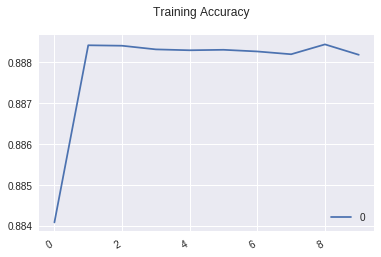

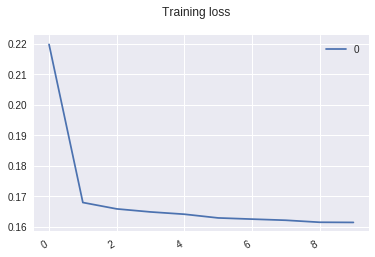

In [65]:

%matplotlib inline
df = pd.DataFrame(history.history['acc'])
df.plot(subplots=True, grid=True,title='Training Accuracy')
df = pd.DataFrame(history.history['loss'])
df.plot(subplots=True, grid=True,title='Training loss')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3b59ff0f0>],
      dtype=object)

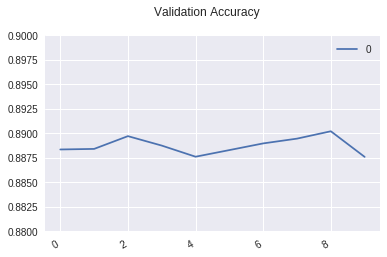

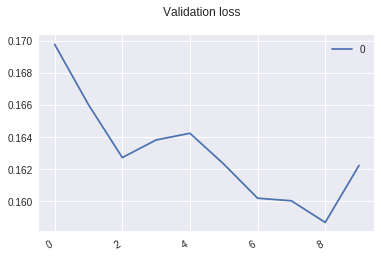

In [66]:

%matplotlib inline
df = pd.DataFrame(history.history['val_acc'])
df.plot(subplots=True, grid=True,title='Validation Accuracy',ylim=(0.88,0.9))
df = pd.DataFrame(history.history['val_loss'])
df.plot(subplots=True, grid=True,title='Validation loss')

# SHUFFLED DATASET

In [40]:
shuffledLeftImg,shuffledRightImg,shuffledTarget = generateValidationSet(shuffled_validation_data)
shuffledLeftMat,shuffledRightMat = generateVaildationImageSet(shuffledValidImagePath,shuffledLeftImg,shuffledRightImg)
shuffledTrainMat = generateTraininigImageSet(shuffledTrainImagePath)

(5288, 64, 64, 1)
(5288, 64, 64, 1)
(11823, 64, 64, 1)


In [49]:
shuffledAutoencoder = createAutoEncoder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 8)         584       
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
__________

In [50]:
shuffledhistory,shuffledTrainedAutoencoder = runAutoncoder(shuffledTrainMat,shuffledAutoencoder)

Epoch 1/10
295/295 [==============================] - 12s 39ms/step - loss: 0.2032 - acc: 0.8885 - val_loss: 0.1627 - val_acc: 0.8921
Epoch 2/10
295/295 [==============================] - 10s 35ms/step - loss: 0.1621 - acc: 0.8915 - val_loss: 0.1614 - val_acc: 0.8913
Epoch 3/10
295/295 [==============================] - 10s 35ms/step - loss: 0.1611 - acc: 0.8913 - val_loss: 0.1597 - val_acc: 0.8918
Epoch 4/10
295/295 [==============================] - 10s 35ms/step - loss: 0.1601 - acc: 0.8913 - val_loss: 0.1582 - val_acc: 0.8916
Epoch 5/10
295/295 [==============================] - 10s 35ms/step - loss: 0.1593 - acc: 0.8912 - val_loss: 0.1574 - val_acc: 0.8914
Epoch 6/10
295/295 [==============================] - 10s 35ms/step - loss: 0.1585 - acc: 0.8913 - val_loss: 0.1561 - val_acc: 0.8927
Epoch 7/10
295/295 [==============================] - 10s 35ms/step - loss: 0.1578 - acc: 0.8913 - val_loss: 0.1574 - val_acc: 0.8912
Epoch 8/10
295/295 [==============================] - 10s 35ms

In [51]:
shuffledEncoder = Model(shuffledTrainedAutoencoder.inputs, shuffledTrainedAutoencoder.get_layer('latent').output)
shuffledEncoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 8)         584       
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
__________

In [0]:

shuffled_left_img_encoded = shuffledEncoder.predict(shuffledLeftMat)
shuffled_right_img_encoded = shuffledEncoder.predict(shuffledRightMat)

In [0]:
shuffledPredicted = []

for i in range(0,len(shuffled_left_img_encoded)):
    a = shuffled_left_img_encoded[i]
    b = shuffled_right_img_encoded[i]
   
    shuffledPredicted.append(cos_sim(a,b))

In [54]:
print("shuffled Training Accuracy : " + str((shuffledhistory.history['acc'][4])*100))
print("shuffled Training Loss : " + str((shuffledhistory.history['loss'][4])))
print("shuffled Validation Accuracy while training on split data : " + str((shuffledhistory.history['val_acc'][4])*100))
print("shuffled Validation loss while training on split data: " + str((shuffledhistory.history['val_loss'][4])))
print("shuffled Validation/Test Dataset Accuracy: "+ str(roc_auc_score(shuffledTarget, shuffledPredicted)*100))
print("shuffled Validation/Test Dataset Average Precision Score: "+
      str(average_precision_score(shuffledTarget, shuffledPredicted)*100))

shuffled Training Accuracy : 89.12533267070957
shuffled Training Loss : 0.159237038613681
shuffled Validation Accuracy while training on split data : 89.13931701329122
shuffled Validation loss while training on split data: 0.15739646842775418
shuffled Validation/Test Dataset Accuracy: 79.05288513255256
shuffled Validation/Test Dataset Average Precision Score: 79.62750603975344


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3b6bc75f8>],
      dtype=object)

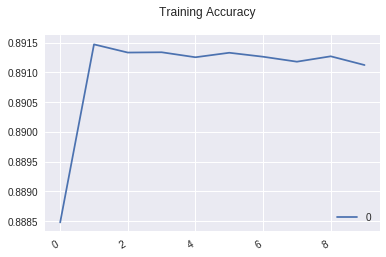

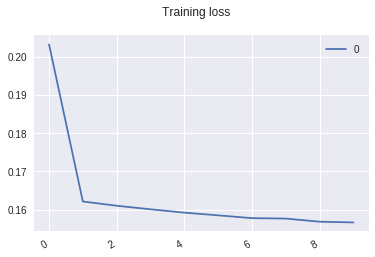

In [55]:

%matplotlib inline
df = pd.DataFrame(shuffledhistory.history['acc'])
df.plot(subplots=True, grid=True,title='Training Accuracy')
df = pd.DataFrame(shuffledhistory.history['loss'])
df.plot(subplots=True, grid=True,title='Training loss')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3b6baf240>],
      dtype=object)

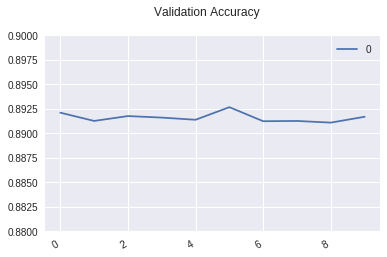

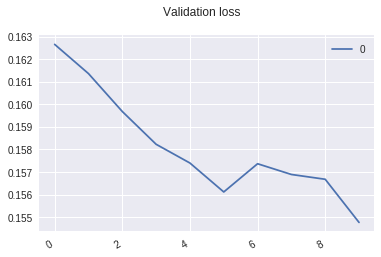

In [56]:

%matplotlib inline
df = pd.DataFrame(shuffledhistory.history['val_acc'])
df.plot(subplots=True, grid=True,title='Validation Accuracy',ylim=(0.88,0.9))
df = pd.DataFrame(shuffledhistory.history['val_loss'])
df.plot(subplots=True, grid=True,title='Validation loss')

# UNSEEN DATASET

In [67]:
unseenLeftImg,unseenRightImg,unseenTarget = generateValidationSet(unseen_validation_data)
unseenLeftMat,unseenRightMat = generateVaildationImageSet(unseenValidImagePath,unseenLeftImg,unseenRightImg)
unseenTrainMat = generateTraininigImageSet(unseenTrainImagePath)

(7580, 64, 64, 1)
(7580, 64, 64, 1)
(12906, 64, 64, 1)


In [68]:
unseenAutoencoder = createAutoEncoder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 16, 16, 8)         584       
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
__________

In [69]:
unseenhistory,unseenTrainedAutoencoder = runAutoncoder(unseenTrainMat,unseenAutoencoder)

Epoch 1/10
322/322 [==============================] - 13s 39ms/step - loss: 0.2044 - acc: 0.8853 - val_loss: 0.1687 - val_acc: 0.8883
Epoch 2/10
322/322 [==============================] - 11s 35ms/step - loss: 0.1684 - acc: 0.8877 - val_loss: 0.1653 - val_acc: 0.8885
Epoch 3/10
322/322 [==============================] - 11s 35ms/step - loss: 0.1673 - acc: 0.8877 - val_loss: 0.1664 - val_acc: 0.8876
Epoch 4/10
322/322 [==============================] - 11s 35ms/step - loss: 0.1664 - acc: 0.8878 - val_loss: 0.1651 - val_acc: 0.8881
Epoch 5/10
322/322 [==============================] - 11s 35ms/step - loss: 0.1655 - acc: 0.8878 - val_loss: 0.1640 - val_acc: 0.8888
Epoch 6/10
322/322 [==============================] - 11s 35ms/step - loss: 0.1655 - acc: 0.8876 - val_loss: 0.1649 - val_acc: 0.8877
Epoch 7/10
322/322 [==============================] - 11s 34ms/step - loss: 0.1643 - acc: 0.8878 - val_loss: 0.1634 - val_acc: 0.8877
Epoch 8/10
322/322 [==============================] - 11s 34ms

In [70]:
unseenEncoder = Model(unseenTrainedAutoencoder.inputs, unseenTrainedAutoencoder.get_layer('latent').output)
unseenEncoder.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 16, 16, 8)         584       
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
__________

In [0]:
unseen_left_img_encoded = unseenEncoder.predict(unseenLeftMat)
unseen_right_img_encoded = unseenEncoder.predict(unseenRightMat)

In [0]:
unseenPredicted = []

for i in range(0,len(unseen_left_img_encoded)):
    a = unseen_left_img_encoded[i]
    b = unseen_right_img_encoded[i]
   
    unseenPredicted.append(cos_sim(a,b))

In [73]:
print("unseen Training Accuracy : " + str((unseenhistory.history['acc'][4])*100))
print("unseen Training Loss : " + str((unseenhistory.history['loss'][4])))
print("unseen Validation Accuracy while training on split data : " + str((unseenhistory.history['val_acc'][4])*100))
print("unseen Validation loss while training on split data: " + str((unseenhistory.history['val_loss'][4])))
print("unseen Validation/Test Dataset Accuracy: "+ str(roc_auc_score(unseenTarget, unseenPredicted)*100))
print("unseen Validation/Test Dataset Average Precision Score: "+
      str(average_precision_score(unseenTarget, unseenPredicted)*100))

unseen Training Accuracy : 88.77698688992628
unseen Training Loss : 0.16553488468734662
unseen Validation Accuracy while training on split data : 88.88240318096227
unseen Validation loss while training on split data: 0.16399267519381208
unseen Validation/Test Dataset Accuracy: 76.93016617818034
unseen Validation/Test Dataset Average Precision Score: 80.04837068080845


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3b58c6828>],
      dtype=object)

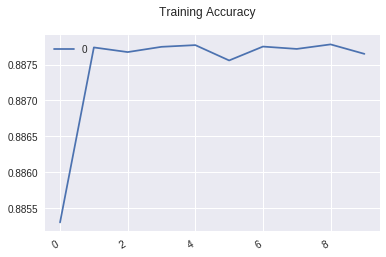

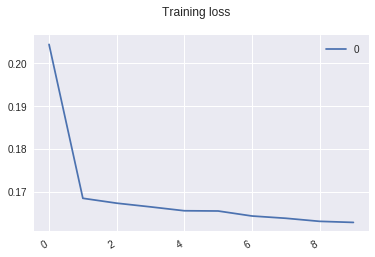

In [74]:

%matplotlib inline
df = pd.DataFrame(unseenhistory.history['acc'])
df.plot(subplots=True, grid=True,title='Training Accuracy')
df = pd.DataFrame(unseenhistory.history['loss'])
df.plot(subplots=True, grid=True,title='Training loss')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc39bf10048>],
      dtype=object)

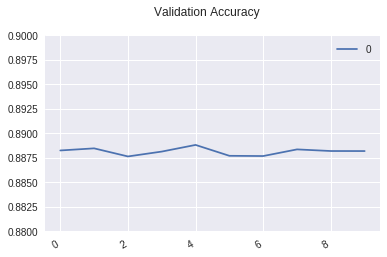

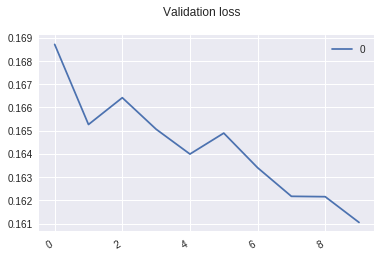

In [75]:

%matplotlib inline
df = pd.DataFrame(unseenhistory.history['val_acc'])
df.plot(subplots=True, grid=True,title='Validation Accuracy',ylim=(0.88,0.9))
df = pd.DataFrame(unseenhistory.history['val_loss'])
df.plot(subplots=True, grid=True,title='Validation loss')